In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from segmenter import *
from classifier import *
from classifier import ClassifierTrainer
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [3]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_lesion_seg'
# test_seg_csv = PATH / 'ISIC/test_seg_isic17.csv'

test_df_csv = PATH / 'ISIC/test_isic17.csv'

train_seg_csv = PATH / 'train_seg_isic17_dermo.csv'

test_seg_csv = PATH / 'ISIC/test_seg_isic17.csv'

train_test_csv =  PATH / 'train_test_Mel_seg_isic17_dermo.csv'

test_mel_cls_seg_p = PATH / 'ISIC/test_Mel_seg_isic17_dermo.csv'


%ls $PATH

dermofit/                        train_multi_half_ia_nervi.csv*
ISIC/                            train_multi_mel.csv*
isic18_p3_test_data*             train_multi_no_ia_nervi.csv*
isic_archive/                    train_multi_raw.csv*
models/                          train_multi_raw_half_ia_nervi.csv*
ph2dataset/                      train_multi_raw_no_ia_nervi.csv*
test_isic17_dermofitLabels.csv*  train_multi_sk.csv*
tmp/                             train_seg_isic17_dermo.csv*
train_dermofit_isic17.csv*       train_test_Mel_seg_isic17_dermo.csv*
train_Mel_seg_isic17_dermo.csv*  val_isic17.csv*
train_multi.csv*


In [13]:
tr_df = pd.read_csv(train_df_csv, header=None, index_col=0)
tr_df['mel_cls'] = (tr_df[1] == 'melanoma').astype(int)

tr_df.head()

,1,mel_cls
0,,
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000000.jpg,nevus,0
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000001.jpg,nevus,0
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000002.jpg,melanoma,1
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000003.jpg,nevus,0
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000004.jpg,melanoma,1


In [17]:
mel_cls_seg_p = PATH / 'train_Mel_seg_isic17_dermo.csv'
tr_df.drop(columns=1).to_csv(mel_cls_seg_p)

### Testset

In [3]:
tst_df = pd.read_csv(test_df_csv, index_col='image_id')
tst_df['mel_cls'] = (tst_df['classes'] == 'melanoma').astype(int)
# tst_df['mel_cls'].value_counts().plot(kind='barh')
tst_df.head()

,classes,mel_cls
image_id,,
ISIC_0012086,seborrheic_keratosis,0
ISIC_0012092,nevus,0
ISIC_0012095,nevus,0
ISIC_0012134,seborrheic_keratosis,0
ISIC_0012136,seborrheic_keratosis,0


In [28]:
tst_df.drop(columns='classes').to_csv(test_mel_cls_seg_p)

In [45]:
test_df_path = tst_df.drop(columns='classes')
test_df_path.index = test_folder + '/' + test_df_path.index + '.jpg'
train_test_df = pd.concat([tr_df.drop(columns=1), test_df_path])
train_test_val_idx = range(len(tr_df.drop(columns=1)), len(train_test_df))

train_test_df.to_csv(train_test_csv)
train_test_df.tail()

,mel_cls
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0016068.jpg,0
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0016069.jpg,0
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0016070.jpg,0
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0016071.jpg,0
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0016072.jpg,0


In [ ]:
train_test_val_idx = range(len(tr_df.drop(columns=1)), len(train_test_df))

In [4]:
train_test_val_idx = range(3450, 4050)  # hard coded from above code

## Setup Trainer

In [4]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=resnet101
# image size
sz=128
bs=64
train_csv = train_seg_csv
trlen = len(pd.read_csv(train_csv))
val_idx = list(range(trlen - 150, trlen))
test_csv = test_seg_csv
w_name = arch.__name__ + '_seglessions_mel_valontest'

trainer = ClassifierTrainer(PATH, arch, sz, bs, train_csv, test_folder=test_folder, val_idx=val_idx, sn=w_name,
                  num_workers=8, test_csv=test_csv, precom=False)
# trainer.lr_find()

Saving model as "resnet101_seglessions_mel_valontest"
Dataset has: ['keratosis', 'melanoma', 'nevus'] classes


In [11]:
trainer.load(w_name + '_1')
trainer.learn.precompute = False

 90%|█████████ | 47/52 [00:57<00:06,  1.22s/it, loss=2.02]

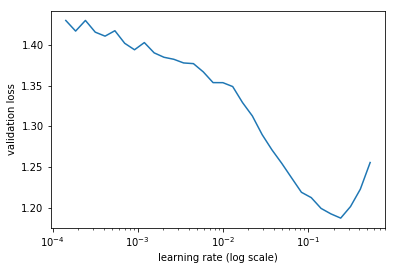

In [4]:
trainer.lr_find()

In [3]:
# for i in range(min(len(trainer.data.classes),10)): sample_ims(PATH, i, trainer.data, numimgs=4, figsize=(10,5))

In [5]:
trainer.set_lr(1e-2)
trainer.init_fit(w_name + '_1')

epoch      trn_loss   val_loss   accuracy                  
    0      0.808006   0.791453   0.6       
    1      0.671832   0.696063   0.706667                  



epoch      trn_loss   val_loss   accuracy                  
    0      0.58108    0.705648   0.686667  
    1      0.560641   0.684752   0.686667                  

Saved weights as "resnet101_seglessions_mel_valontest_1"


In [25]:
# trainer.load(w_name + '_1')
tst_res = trainer.test_eval(sf=False)
val_res = trainer.test_val(sf=False)
# print('-'*50)
# trainer.test_eval()

Loading ys from csv; shape (600,); vals [0 1 2]; in folder "ISIC/ISIC-2017_Test_v2_Data_lesion_seg"
Accuracy = 0.12
Confusion Matrix:
[[  7  37  73]
 [ 28  26 339]
 [ 39  15  36]]
AUC for class 0, id keratosis = 0.51
AUC for class 1, id melanoma = 0.34
AUC for class 2, id nevus = 0.17
Accuracy = 0.69
Confusion Matrix:
[[21  3 18]
 [ 3  8 19]
 [ 2  2 74]]
AUC for class 0, id keratosis = 0.93
AUC for class 1, id melanoma = 0.80
AUC for class 2, id nevus = 0.87


In [27]:
trainer.inter_fit(w_name + '_2')
val_res_2 = trainer.test_val(tta=False, sf=False)
tst_res_2 = trainer.test_eval(tta=False, sf=False)

epoch      trn_loss   val_loss   accuracy                  
    0      0.539833   0.676158   0.74      
    1      0.546979   0.663737   0.713333                  
    2      0.536566   0.685786   0.686667                  

Saved weights as "resnet101_seglessions_mel_valontest_2"
Accuracy = 0.69
Confusion Matrix:
[[26  2 14]
 [ 4  5 21]
 [ 3  3 72]]
AUC for class 0, id keratosis = 0.93
AUC for class 1, id melanoma = 0.78
AUC for class 2, id nevus = 0.87
Loading ys from csv; shape (600,); vals [0 1 2]; in folder "ISIC/ISIC-2017_Test_v2_Data_lesion_seg"
Accuracy = 0.12
Confusion Matrix:
[[ 15  34  68]
 [ 31  24 338]
 [ 43  14  33]]
AUC for class 0, id keratosis = 0.55
AUC for class 1, id melanoma = 0.32
AUC for class 2, id nevus = 0.16


In [28]:
trainer.final_fit(w_name + '_3')

  2%|▏         | 1/52 [00:03<02:56,  3.47s/it, loss=0.788]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
val_res_3 = trainer.test_val(tta=False, sf=False)
tst_res_3 = trainer.test_eval(tta=True, sf=True)

In [5]:
def den_im(im):
    den = trainer.data.trn_ds.denorm
    im = im[np.newaxis, ...]
    dim = den(im.squeeze()).squeeze()
    return dim

# for i in [50, 33]:
#     show_img(den_im(voutnp[0][i,...]))
#     show_img(den_im(toutnp[0][i,...]))

In [19]:
sum(val_res[0] == test_res[0])

460

In [20]:
test_res[2], val_res[2]

(0.7183333333333334, 0.785)